# Build co-occurence network for SSU table

## Open questions and todos
1. How do deal with taxonomy which has hits on different levels, including unidentified bacteria adds no information and should be remove. #done
2. Calculate p-values and FDR testing. #done

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import logging
from typing import Dict
from scipy.stats import spearmanr, pearsonr

from mgo.udal import UDAL
# sys.path.insert(0, '/home/david-palecek/coding/emo-bon/marine-omics-methods')

# All low level functions are imported from the momics package
from momics.taxonomy import (
    remove_high_taxa,
    pivot_taxonomic_data,
    prevalence_cutoff,
    rarefy_table,
    split_metadata,
    split_taxonomic_data,
    split_taxonomic_data_pivoted,
    compute_bray_curtis,
    fill_taxonomy_placeholders,
    fdr_pvals,
)
from momics.utils import load_and_clean
from momics.networks import (
    interaction_to_graph,
    interaction_to_graph_with_pvals,
    pairwise_jaccard_lower_triangle,
    build_interaction_graphs,
)
from momics.plotting import plot_network
from momics.stats import (
    spearman_from_taxonomy,
    plot_fdr,
    plot_association_histogram,
)

# plot the bray curtis matrix
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

## Loading

In [2]:
logger = logging.getLogger(name="Co-occurrence network analysis")
FORMAT = "%(levelname)s | %(name)s | %(message)s"  # for logger
logging.basicConfig(format=FORMAT, level=logging.INFO, force=True)
udal = UDAL()

In [3]:
if 'google.colab' in str(get_ipython()):
    root_folder = os.path.abspath(os.path.join('/content/momics-demos'))
else:
    root_folder = os.path.abspath(os.path.join('../../'))


assets_folder = os.path.join(root_folder, 'assets')

In [4]:
def get_valid_samples():
    df_valid = pd.read_csv(
        os.path.join(root_folder, 'data/shipment_b1b2_181.csv')
    )
    return df_valid

valid_samples = get_valid_samples()

In [5]:
# High level function from the momics.utils module
full_metadata, mgf_parquet_dfs = load_and_clean(valid_samples=valid_samples)

/home/david-palecek/miniforge3/envs/momics-demos/lib/python3.13/site-packages/momics/metadata.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["replicate_info"] = (


## Separate tables by metadata/treatments/seasons etc
- rule of thumb is to have > 25 samples per group
- they should be as similar as possible
- other rules in Berry 2014, https://www.frontiersin.org/journals/microbiology/articles/10.3389/fmicb.2014.00219/full

### Procedure
1. Remove low abundance taxa
- I want to first get get list of ref_codes per group
- Then filter the total abundance table (raw data, the first you load as parquet file)
- Pivot and analyze. This means I normalize each subtable separately, is that correct?

### 1. Loading data

In [6]:
ssu = mgf_parquet_dfs['ssu']
ssu.head(15)

abundance superkingdom kingdom  \
source material ID ncbi_tax_id                                   
EMOBON_BPNS_So_5   2157               7.0      Archaea    None   
                   1801616            1.0      Archaea           
                   28890              1.0      Archaea           
                   183968             1.0      Archaea           
                   192989             3.0      Archaea           
                   651137             4.0      Archaea           
                   205957             1.0      Archaea           
                   46769              3.0      Archaea           
                   338190           129.0      Archaea           
                   338191             2.0      Archaea           
                   1033997            6.0      Archaea           
                   2                 86.0     Bacteria    None   
                   2497645            1.0     Bacteria           
                   57723            139.0     Bacteria           
                   204432            23.0     Bacteria           

                                                   phylum  \
source material ID ncbi_tax_id                              
EMOBON_BPNS_So_5   2157                              None   
                   1801616      Candidatus_Woesearchaeota   
                   28890                    Euryarchaeota   
                   183968                   Euryarchaeota   
                   192989                   Nanoarchaeota   
                   651137                  Thaumarchaeota   
                   205957                  Thaumarchaeota   
                   46769                   Thaumarchaeota   
                   338190                  Thaumarchaeota   
                   338191                  Thaumarchaeota   
                   1033997                 Thaumarchaeota   
                   2                                 None   
                   2497645                                  
                   57723                    Acidobacteria   
                   204432                   Acidobacteria   

                                              class                  order  \
source material ID ncbi_tax_id                                               
EMOBON_BPNS_So_5   2157                        None                   None   
                   1801616                     None                   None   
                   28890                       None                   None   
                   183968               Thermococci                   None   
                   192989                      None                   None   
                   651137                      None                   None   
                   205957                                    Cenarchaeales   
                   46769                                     Cenarchaeales   
                   338190                                 Nitrosopumilales   
                   338191                                 Nitrosopumilales   
                   1033997          Nitrososphaeria      Nitrososphaerales   
                   2                           None                   None   
                   2497645      Candidatus_Babeliae  Candidatus_Babeliales   
                   57723                       None                   None   
                   204432            Acidobacteriia                   None   

                                                family           genus species  
source material ID ncbi_tax_id                                                  
EMOBON_BPNS_So_5   2157                           None            None    None  
                   1801616                        None            None    None  
                   28890                          None            None    None  
                   183968                         None            None    None  
                   192989                         None    

In [7]:
ssu['kingdom'].unique()


array([None, '', 'Fungi', 'Metazoa', 'Viridiplantae'], dtype=object)

In [8]:
# Identify object columns
categorical_columns = sorted(full_metadata.select_dtypes(include=['object', "boolean"]).columns)

# Convert them all at once to category
full_metadata = full_metadata.astype({col: 'category' for col in categorical_columns})

if not isinstance(full_metadata['season'].dtype, pd.CategoricalDtype):
        raise ValueError(f"Column 'season' is not categorical (object dtype).")

### 2.0 Infer taxonomic lineage if lower taxa was identified

In [9]:
taxonomy_cols = ['superkingdom', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
ssu_filled = fill_taxonomy_placeholders(ssu, taxonomy_cols)
ssu_filled.head(20)

abundance superkingdom  \
source material ID ncbi_tax_id                           
EMOBON_BPNS_So_5   2157               7.0      Archaea   
                   1801616            1.0      Archaea   
                   28890              1.0      Archaea   
                   183968             1.0      Archaea   
                   192989             3.0      Archaea   
                   651137             4.0      Archaea   
                   205957             1.0      Archaea   
                   46769              3.0      Archaea   
                   338190           129.0      Archaea   
                   338191             2.0      Archaea   
                   1033997            6.0      Archaea   
                   2                 86.0     Bacteria   
                   2497645            1.0     Bacteria   
                   57723            139.0     Bacteria   
                   204432            23.0     Bacteria   
                   1281902            3.0     Bacteria   
                   2048906            1.0     Bacteria   
                   1562565            1.0     Bacteria   
                   442869             2.0     Bacteria   
                   2562242          361.0     Bacteria   

                                                                      kingdom  \
source material ID ncbi_tax_id                                                  
EMOBON_BPNS_So_5   2157                                                  None   
                   1801616             unclassified_Candidatus_Woesearchaeota   
                   28890                           unclassified_Euryarchaeota   
                   183968                          unclassified_Euryarchaeota   
                   192989                          unclassified_Nanoarchaeota   
                   651137                         unclassified_Thaumarchaeota   
                   205957                         unclassified_Thaumarchaeota   
                   46769                          unclassified_Thaumarchaeota   
                   338190                         unclassified_Thaumarchaeota   
                   338191                         unclassified_Thaumarchaeota   
                   1033997                        unclassified_Thaumarchaeota   
                   2                                                     None   
                   2497645      unclassified_unclassified_Candidatus_Babeliae   
                   57723                           unclassified_Acidobacteria   
                   204432                          unclassified_Acidobacteria   
                   1281902                         unclassified_Acidobacteria   
                   2048906                         unclassified_Acidobacteria   
                   1562565                         unclassified_Acidobacteria   
                   442869                          unclassified_Acidobacteria   
                   2562242                         unclassified_Acidobacteria   

                                                          phylum  \
source material ID ncbi_tax_id                                     
EMOBON_BPNS_So_5   2157                                     None   
                   1801616             Candidatus_Woesearchaeota   
                   28890                           Euryarchaeota   
                   183968                          Euryarchaeota   
                   192989                          Nanoarchaeota   
                   651137                         Thaumarchaeota   
                   205957                         Thaumarchaeota   
                   46769                          Thaumarchaeota   
                   338190                         Thaumarchaeota   
                   338191                         Thaumarchaeota   
                   1033997                        Thaumarchaeota   
                   2                                        None   
                   2

In [10]:
for col in taxonomy_cols:
    assert ssu_filled[ssu_filled[col] == ''].empty is True, f"There are empty '{col}' values in the DataFrame."

### 2.1 Remove high taxa which is not identified down certain level

In [11]:
ssu_filled.head()

abundance superkingdom  \
source material ID ncbi_tax_id                           
EMOBON_BPNS_So_5   2157               7.0      Archaea   
                   1801616            1.0      Archaea   
                   28890              1.0      Archaea   
                   183968             1.0      Archaea   
                   192989             3.0      Archaea   

                                                               kingdom  \
source material ID ncbi_tax_id                                           
EMOBON_BPNS_So_5   2157                                           None   
                   1801616      unclassified_Candidatus_Woesearchaeota   
                   28890                    unclassified_Euryarchaeota   
                   183968                   unclassified_Euryarchaeota   
                   192989                   unclassified_Nanoarchaeota   

                                                   phylum        class order  \
source material ID ncbi_tax_id                                                 
EMOBON_BPNS_So_5   2157                              None         None  None   
                   1801616      Candidatus_Woesearchaeota         None  None   
                   28890                    Euryarchaeota         None  None   
                   183968                   Euryarchaeota  Thermococci  None   
                   192989                   Nanoarchaeota         None  None   

                               family genus species  
source material ID ncbi_tax_id                       
EMOBON_BPNS_So_5   2157          None  None    None  
                   1801616       None  None    None  
                   28890         None  None    None  
                   183968        None  None    None  
                   192989        None  None    None

In [10]:
print("Original DataFrame shape:", ssu_filled.shape)
ssu_filled = remove_high_taxa(ssu_filled, taxonomy_ranks=taxonomy_cols, tax_level='phylum')
print("Filtered DataFrame shape:", ssu_filled.shape)

Original DataFrame shape: (111320, 9)


  0%|          | 0/218 [00:00<?, ?it/s]

100%|██████████| 218/218 [01:04<00:00,  3.38it/s]
INFO | momics.taxonomy | Number of bad taxa at phylum: 9
INFO | momics.taxonomy | Unmapped taxa at phylum: ['Candidatus_Altiarchaeota', 'Hemichordata', 'Aquificae', 'Coprothermobacterota', 'Candidatus_Verstraetearchaeota', 'Orthonectida', 'Chrysiogenetes', 'Parabasalia', 'Candidatus_Rokubacteria']


Filtered DataFrame shape: (19926, 9)


In [11]:
ssu_filled.head(10)

abundance superkingdom  \
source material ID ncbi_tax_id                           
EMOBON_BPNS_So_5   1801616            1.0      Archaea   
                   28890              2.0      Archaea   
                   192989             3.0      Archaea   
                   651137           145.0      Archaea   
                   2497645            1.0     Bacteria   
                   57723            530.0     Bacteria   
                   201174           312.0     Bacteria   
                   976              271.0     Bacteria   
                   1752727            2.0     Bacteria   
                   1752734            1.0     Bacteria   

                                                                      kingdom  \
source material ID ncbi_tax_id                                                  
EMOBON_BPNS_So_5   1801616             unclassified_Candidatus_Woesearchaeota   
                   28890                           unclassified_Euryarchaeota   
                   192989                          unclassified_Nanoarchaeota   
                   651137                         unclassified_Thaumarchaeota   
                   2497645      unclassified_unclassified_Candidatus_Babeliae   
                   57723                           unclassified_Acidobacteria   
                   201174                         unclassified_Actinobacteria   
                   976                             unclassified_Bacteroidetes   
                   1752727           unclassified_Candidatus_Campbellbacteria   
                   1752734             unclassified_Candidatus_Kaiserbacteria   

                                                          phylum  \
source material ID ncbi_tax_id                                     
EMOBON_BPNS_So_5   1801616             Candidatus_Woesearchaeota   
                   28890                           Euryarchaeota   
                   192989                          Nanoarchaeota   
                   651137                         Thaumarchaeota   
                   2497645      unclassified_Candidatus_Babeliae   
                   57723                           Acidobacteria   
                   201174                         Actinobacteria   
                   976                             Bacteroidetes   
                   1752727           Candidatus_Campbellbacteria   
                   1752734             Candidatus_Kaiserbacteria   

                                              class                  order  \
source material ID ncbi_tax_id                                               
EMOBON_BPNS_So_5   1801616                     None                   None   
                   28890                       None                   None   
                   192989                      None                   None   
                   651137                      None                   None   
                   2497645      Candidatus_Babeliae  Candidatus_Babeliales   
                   57723                       None                   None   
                   201174                      None                   None   
                   976                         None                   None   
                   1752727                     None                   None   
                   1752734                     None                   None   

                                                family genus species  
source material ID ncbi_tax_id                                        
EMOBON_BPNS_So_5   1801616                        None  None    None  
                   28890                          None  None    None  
                   192989                         None  None    None  
                   651137                         None  None    None  
                   2497645      Candidatus_Babeliaceae  None    None  
                   57723                          None  None    None  
                   201174               

### 3. Pivot table

In [13]:
ssu_pivot = pivot_taxonomic_data(ssu_filled)
ssu_pivot.head()

,source material ID,EMOBON_AAOT_Wa_1,EMOBON_AAOT_Wa_2,EMOBON_AAOT_Wa_22,EMOBON_AAOT_Wa_26,EMOBON_AAOT_Wa_27,EMOBON_AAOT_Wa_41,EMOBON_AAOT_Wa_42,EMOBON_AAOT_Wa_46,EMOBON_AAOT_Wa_47,EMOBON_AAOT_Wa_6,...,EMOBON_VB_Wa_4,EMOBON_VB_Wa_41,EMOBON_VB_Wa_42,EMOBON_VB_Wa_43,EMOBON_VB_Wa_44,EMOBON_VB_Wa_5,EMOBON_VB_Wa_93,EMOBON_VB_Wa_94,EMOBON_VB_Wa_96,EMOBON_VB_Wa_97
ncbi_tax_id,taxonomic_concat,,,,,,,,,,,,,,,,,,,,,
976,976;sk_Bacteria;k_unclassified_Bacteroidetes;p_Bacteroidetes;c_;o_;f_;g_;s_,1931,2436,5447,2262,2220,1426,359,4364,3203,2626,...,3017,621,861,3948,3483,4378,346,445,2599,2839
1090,1090;sk_Bacteria;k_unclassified_Chlorobi;p_Chlorobi;c_;o_;f_;g_;s_,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1117,1117;sk_Bacteria;k_unclassified_Cyanobacteria;p_Cyanobacteria;c_;o_;f_;g_;s_,1096,1240,1761,2176,1301,616,404,495,333,1770,...,1079,752,961,3619,2048,1543,428,499,4982,2324
1224,1224;sk_Bacteria;k_unclassified_Proteobacteria;p_Proteobacteria;c_;o_;f_;g_;s_,4940,11968,7510,15800,13775,2482,1334,15904,11331,11880,...,12946,1850,2358,13082,12392,17597,1615,1909,16603,20177
1239,1239;sk_Bacteria;k_unclassified_Firmicutes;p_Firmicutes;c_;o_;f_;g_;s_,26,29,59,19,0,31,8,32,26,0,...,8,52,76,44,25,17,0,23,28,25


### 4. Remove low prevalence taxa  
- prevalence cut-off filter to remove ASVs below a minimum cut-off, which was set to 10% 
- (i.e., ASVs found in fewer than 10% of samples were removed) for the filtered data analyses we present.
- first remove, then rarefy not to waste sequencing depth on uninformative samples or taxa.
- CAREFUL: this refers to prevalence over many samples, not minimal abundance in single sample, which is sometimes used too.

In [14]:
ssu_filt = prevalence_cutoff(ssu_pivot, percent=10, skip_columns=0)
ssu_filt.head()

,source material ID,EMOBON_AAOT_Wa_1,EMOBON_AAOT_Wa_2,EMOBON_AAOT_Wa_22,EMOBON_AAOT_Wa_26,EMOBON_AAOT_Wa_27,EMOBON_AAOT_Wa_41,EMOBON_AAOT_Wa_42,EMOBON_AAOT_Wa_46,EMOBON_AAOT_Wa_47,EMOBON_AAOT_Wa_6,...,EMOBON_VB_Wa_4,EMOBON_VB_Wa_41,EMOBON_VB_Wa_42,EMOBON_VB_Wa_43,EMOBON_VB_Wa_44,EMOBON_VB_Wa_5,EMOBON_VB_Wa_93,EMOBON_VB_Wa_94,EMOBON_VB_Wa_96,EMOBON_VB_Wa_97
ncbi_tax_id,taxonomic_concat,,,,,,,,,,,,,,,,,,,,,
976,976;sk_Bacteria;k_unclassified_Bacteroidetes;p_Bacteroidetes;c_;o_;f_;g_;s_,1931,2436,5447,2262,2220,1426,359,4364,3203,2626,...,3017,621,861,3948,3483,4378,346,445,2599,2839
1117,1117;sk_Bacteria;k_unclassified_Cyanobacteria;p_Cyanobacteria;c_;o_;f_;g_;s_,1096,1240,1761,2176,1301,616,404,495,333,1770,...,1079,752,961,3619,2048,1543,428,499,4982,2324
1224,1224;sk_Bacteria;k_unclassified_Proteobacteria;p_Proteobacteria;c_;o_;f_;g_;s_,4940,11968,7510,15800,13775,2482,1334,15904,11331,11880,...,12946,1850,2358,13082,12392,17597,1615,1909,16603,20177
1239,1239;sk_Bacteria;k_unclassified_Firmicutes;p_Firmicutes;c_;o_;f_;g_;s_,26,29,59,19,0,31,8,32,26,0,...,8,52,76,44,25,17,0,23,28,25
1297,1297;sk_Bacteria;k_unclassified_Deinococcus-Thermus;p_Deinococcus-Thermus;c_;o_;f_;g_;s_,45,0,0,0,0,49,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 5. Rarefy

In [15]:
# Example usage:
ssu_rarefied = rarefy_table(ssu_filt, depth=None, axis=1)
ssu_rarefied.head()

Minimum rarefaction depth: 5467


,,EMOBON_AAOT_Wa_1,EMOBON_AAOT_Wa_2,EMOBON_AAOT_Wa_22,EMOBON_AAOT_Wa_26,EMOBON_AAOT_Wa_27,EMOBON_AAOT_Wa_41,EMOBON_AAOT_Wa_42,EMOBON_AAOT_Wa_46,EMOBON_AAOT_Wa_47,EMOBON_AAOT_Wa_6,...,EMOBON_VB_Wa_4,EMOBON_VB_Wa_41,EMOBON_VB_Wa_42,EMOBON_VB_Wa_43,EMOBON_VB_Wa_44,EMOBON_VB_Wa_5,EMOBON_VB_Wa_93,EMOBON_VB_Wa_94,EMOBON_VB_Wa_96,EMOBON_VB_Wa_97
ncbi_tax_id,taxonomic_concat,,,,,,,,,,,,,,,,,,,,,
976,976;sk_Bacteria;k_unclassified_Bacteroidetes;p_Bacteroidetes;c_;o_;f_;g_;s_,765,644,717,593,637,650,186,916,1000,695,...,890,230,174,984,956,889,272,309,521,531
1117,1117;sk_Bacteria;k_unclassified_Cyanobacteria;p_Cyanobacteria;c_;o_;f_;g_;s_,429,325,272,564,373,266,203,108,104,450,...,316,247,223,866,636,361,342,349,1077,448
1224,1224;sk_Bacteria;k_unclassified_Proteobacteria;p_Proteobacteria;c_;o_;f_;g_;s_,1953,3278,1060,3921,3994,1088,643,3419,3398,3158,...,3779,654,542,3247,3503,3743,1289,1288,3336,3963
1239,1239;sk_Bacteria;k_unclassified_Firmicutes;p_Firmicutes;c_;o_;f_;g_;s_,9,7,9,8,0,9,5,7,10,0,...,2,16,19,17,6,4,0,13,5,7
1297,1297;sk_Bacteria;k_unclassified_Deinococcus-Thermus;p_Deinococcus-Thermus;c_;o_;f_;g_;s_,19,0,0,0,0,16,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 6 Remove replicates

In [16]:
full_metadata['replicate info'].value_counts() > 1

replicate info
VB_water_column_2021-08-23_NA            True
VB_water_column_2021-06-21_NA            True
VB_water_column_2021-12-17_NA            True
VB_water_column_2021-10-18_NA            True
AAOT_water_column_2021-10-15_3-200       True
                                        ...  
OSD74_water_column_2021-08-31_3-200     False
HCMR-1_water_column_2021-06-28_3-200    False
OOB_soft_sediment_2021-06-08_NA         False
ESC68N_water_column_2021-11-04_0.2-3    False
ESC68N_water_column_2021-11-04_3-200    False
Name: count, Length: 90, dtype: bool

In [17]:
# Remove duplicate rows based on the 'replicate_info' column, keeping the first occurrence
filtered_metadata = full_metadata.drop_duplicates(subset='replicate info', keep='first')
filtered_metadata.shape


(90, 98)

### 7. Split to groups

In [18]:
# test of metadata split
FACTOR = 'environment (material)'
groups = split_metadata(
    filtered_metadata,
    FACTOR
)

In [19]:
for groups_key in list(groups.keys()):
    print(f"{groups_key}: {len(groups[groups_key])} samples")
    if len(groups[groups_key]) < 3:
        del groups[groups_key]
        print(f"Warning: {groups_key} has less than 3 samples, therefore removed.")

sediment [ENVO:00002007]: 13 samples
seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042]: 66 samples
lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042]: 6 samples
seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]: 2 samples
lagoon [ENVO_00000038]; sediment [ENVO:00002007]: 3 samples


In [20]:
# pivot and filter the ssu
split_taxonomy = split_taxonomic_data_pivoted(
    ssu_rarefied,
    groups
)

for key, value in split_taxonomy.items():
    print(f"{key}: {value.shape[0]} rows, {value.shape[1]} columns")
# split_taxonomy.keys(),

print(ssu_rarefied.shape)

Removed 121 rows with all zeros for sediment [ENVO:00002007].
Removed 2 rows with all zeros for seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042].
Removed 124 rows with all zeros for lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042].
Removed 191 rows with all zeros for lagoon [ENVO_00000038]; sediment [ENVO:00002007].
sediment [ENVO:00002007]: 150 rows, 13 columns
seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042]: 269 rows, 66 columns
lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042]: 147 rows, 6 columns
lagoon [ENVO_00000038]; sediment [ENVO:00002007]: 80 rows, 3 columns
(271, 181)


### 8. Calculate associations

#### Dissimilarity matrix and Spearman's correlation

In [21]:
# compute Bray-Curtis dissimilarity for each factor separately
# I think only taxa makes sense
bray_taxa = {}
for factor, df in split_taxonomy.items():
    bray_taxa[factor] = compute_bray_curtis(df, skip_cols=0, direction='taxa')

In [22]:
spearman_taxa = spearman_from_taxonomy(split_taxonomy)

In [23]:
# spearman_taxa['Summer']['p_vals'].head()
spearman_taxa['sediment [ENVO:00002007]']['p_vals'].head()

,ncbi_tax_id,976,1117,1224,1239,2825,2836,2864,2867,2870,2910,...,2497438,2497644,2497645,2587759,2604748,2608109,2683628,2683630,2687318,2699530
,taxonomic_concat,976;sk_Bacteria;k_unclassified_Bacteroidetes;p_Bacteroidetes;c_;o_;f_;g_;s_,1117;sk_Bacteria;k_unclassified_Cyanobacteria;p_Cyanobacteria;c_;o_;f_;g_;s_,1224;sk_Bacteria;k_unclassified_Proteobacteria;p_Proteobacteria;c_;o_;f_;g_;s_,1239;sk_Bacteria;k_unclassified_Firmicutes;p_Firmicutes;c_;o_;f_;g_;s_,2825;sk_Eukaryota;k_unclassified_unclassified_Chrysophyceae;p_unclassified_Chrysophyceae;c_Chrysophyceae;o_;f_;g_;s_,2836;sk_Eukaryota;k_unclassified_Bacillariophyta;p_Bacillariophyta;c_;o_;f_;g_;s_,2864;sk_Eukaryota;k_unclassified_unclassified_Dinophyceae;p_unclassified_Dinophyceae;c_Dinophyceae;o_;f_;g_;s_,2867;sk_Eukaryota;k_unclassified_unclassified_Dinophyceae;p_unclassified_Dinophyceae;c_Dinophyceae;o_Peridiniales;f_Peridiniaceae;g_Peridinium;s_,2870;sk_Eukaryota;k_unclassified_unclassified_Phaeophyceae;p_unclassified_Phaeophyceae;c_Phaeophyceae;o_;f_;g_;s_,2910;sk_Eukaryota;k_unclassified_unclassified_Dinophyceae;p_unclassified_Dinophyceae;c_Dinophyceae;o_Peridiniales;f_;g_;s_,...,2497438;sk_Eukaryota;k_unclassified_Perkinsozoa;p_Perkinsozoa;c_;o_;f_;g_;s_,2497644;sk_Bacteria;k_unclassified_unclassified_Candidatus_Babeliae;p_unclassified_Candidatus_Babeliae;c_Candidatus_Babeliae;o_Candidatus_Babeliales;f_;g_;s_,2497645;sk_Bacteria;k_unclassified_unclassified_Candidatus_Babeliae;p_unclassified_Candidatus_Babeliae;c_Candidatus_Babeliae;o_Candidatus_Babeliales;f_Candidatus_Babeliaceae;g_;s_,2587759;sk_Eukaryota;k_unclassified_unclassified_unclassified_Pirsoniales;p_unclassified_unclassified_Pirsoniales;c_unclassified_Pirsoniales;o_Pirsoniales;f_;g_;s_,2604748;sk_Eukaryota;k_unclassified_Endomyxa;p_Endomyxa;c_;o_;f_;g_;s_,2608109;sk_Eukaryota;k_unclassified_Haptista;p_Haptista;c_;o_;f_;g_;s_,2683628;sk_Eukaryota;k_unclassified_unclassified_Bigyra;p_unclassified_Bigyra;c_Bigyra;o_;f_;g_;s_,2683630;sk_Eukaryota;k_unclassified_unclassified_Bigyra;p_unclassified_Bigyra;c_Bigyra;o_Nanomonadea;f_;g_;s_,2687318;sk_Eukaryota;k_unclassified_unclassified_Filasterea;p_unclassified_Filasterea;c_Filasterea;o_;f_;g_;s_,2699530;sk_Eukaryota;k_unclassified_unclassified_Bigyra;p_unclassified_Bigyra;c_Bigyra;o_Oblongichytrida;f_;g_;s_
ncbi_tax_id,taxonomic_concat,,,,,,,,,,,,,,,,,,,,,
976,976;sk_Bacteria;k_unclassified_Bacteroidetes;p_Bacteroidetes;c_;o_;f_;g_;s_,0.000000,0.893522,0.002112,0.006088,0.802187,0.907661,0.019395,0.023725,0.111173,0.065963,...,0.238389,0.105289,0.405215,0.014232,0.553568,0.864967,0.777223,0.614737,0.232044,0.133260
1117,1117;sk_Bacteria;k_unclassified_Cyanobacteria;p_Cyanobacteria;c_;o_;f_;g_;s_,0.893522,0.000000,0.266421,0.546634,0.614244,0.000003,0.416792,0.577407,0.304237,0.023478,...,0.085721,0.116443,0.338252,0.087400,0.256626,0.070985,0.020574,0.192313,0.942349,0.110058
1224,1224;sk_Bacteria;k_unclassified_Proteobacteria;p_Proteobacteria;c_;o_;f_;g_;s_,0.002112,0.266421,0.000000,0.127524,0.446742,0.510614,0.030070,0.127078,0.304937,0.023725,...,0.056059,0.089243,0.049904,0.008658,0.760141,0.754828,0.594765,0.614737,0.560312,0.133260
1239,1239;sk_Bacteria;k_unclassified_Firmicutes;p_Firmicutes;c_;o_;f_;g_;s_,0.006088,0.546634,0.127524,0.000000,1.000000,0.441943,0.005588,0.229503,0.446742,0.587869,...,0.409364,0.304777,0.968900,0.200352,0.760141,0.754828,0.680634,0.111173,0.174601,0.874222
2825,2825;sk_Eukaryota;k_unclassified_unclassified_Chrysophyceae;p_unclassified_Chrysophyceae;c_Chrysophyceae;o_;f_;g_;s_,0.802187,0.614244,0.446742,1.000000,0.000000,1.000000,0.301418,0.689732,0.786654,0.689732,...,0.534053,0.349342,0.403774,0.608695,0.537487,0.689732,0.797774,0.786654,0.528757,0.605917


### 9. FDR control

In [24]:
PVAL = 0.05  # Define a p-value threshold for FDR correction
for factor, d in spearman_taxa.items():
    pvals_fdr = fdr_pvals(d['p_vals'], pval_cutoff=PVAL)
    spearman_taxa[factor]['p_vals_fdr'] = pvals_fdr

### FACTOR: sediment [ENVO:00002007] ###
Significant associations before 1972 and after 90
Associations significant before FDR but not after: 1882
### FACTOR: seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042] ###
Significant associations before 16039 and after 3614
Associations significant before FDR but not after: 12425
### FACTOR: lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042] ###
Significant associations before 1743 and after 433
Associations significant before FDR but not after: 1310
### FACTOR: lagoon [ENVO_00000038]; sediment [ENVO:00002007] ###
Significant associations before 1336 and after 628
Associations significant before FDR but not after: 708


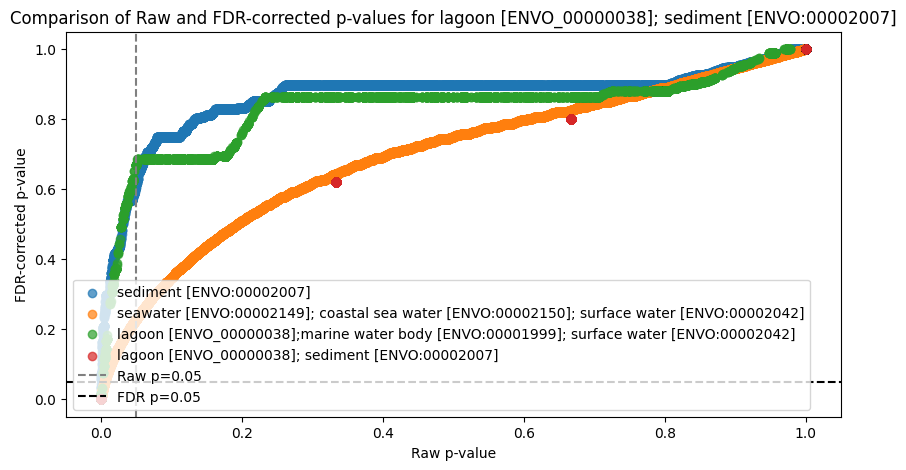

In [26]:
plot_fdr(spearman_taxa, PVAL)

### --. Display and test network building

#### Bray-Curtis distances

values in the triangle: 11175
values in the triangle: 36046
values in the triangle: 10731
values in the triangle: 3160


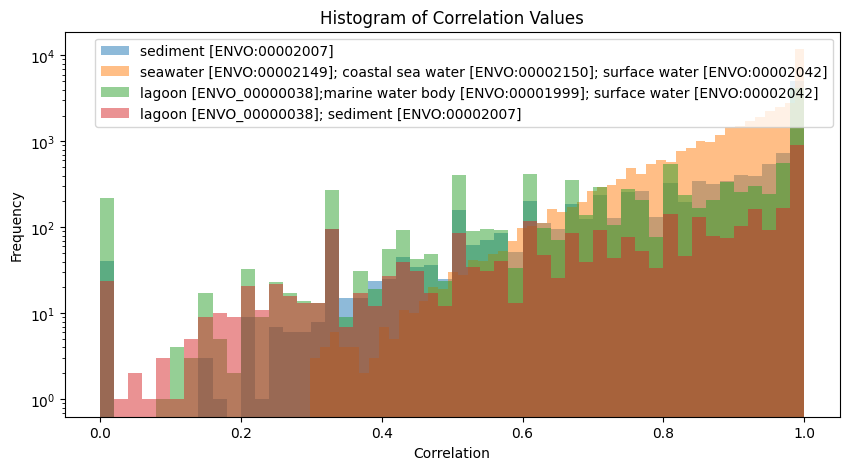

In [27]:
plot_association_histogram(bray_taxa)

In [29]:
first_key = list(bray_taxa.keys())[0]
bray_taxa[first_key].head()

ncbi_tax_id,976,1117,1224,1239,2825,2836,2864,2867,2870,2910,...,2497438,2497644,2497645,2587759,2604748,2608109,2683628,2683630,2687318,2699530
ncbi_tax_id,,,,,,,,,,,,,,,,,,,,,
976,0.000000,0.775499,0.838407,0.580742,0.999358,0.682394,0.879940,0.998076,0.999358,0.998076,...,0.995517,0.987879,0.987879,0.997436,0.983450,0.998076,0.984713,0.999358,0.997436,0.998076
1117,0.775499,0.000000,0.978016,0.557662,0.994937,0.205674,0.403035,0.984887,0.994937,0.984887,...,0.965087,0.907990,0.912833,0.979899,0.876190,0.984887,0.885167,0.994937,0.979899,0.984887
1224,0.838407,0.978016,0.000000,0.951985,0.999944,0.967095,0.988836,0.999831,0.999944,0.999831,...,0.999605,0.998929,0.998929,0.999774,0.998534,0.999831,0.998647,0.999944,0.999774,0.999831
1239,0.580742,0.557662,0.951985,0.000000,0.997709,0.576792,0.633987,0.993143,0.997709,0.993143,...,0.984073,0.957351,0.959596,0.990868,0.942094,0.993143,0.946429,0.997709,0.990868,0.993143
2825,0.999358,0.994937,0.999944,0.997709,0.000000,0.996633,0.990000,1.000000,1.000000,1.000000,...,1.000000,0.900000,1.000000,1.000000,1.000000,1.000000,0.920000,1.000000,1.000000,1.000000


In [30]:
for factor, df in bray_taxa.items():
    print(f"Factor: {factor}", df.shape)
    nodes, edges_pos, edges_neg = interaction_to_graph(df, pos_cutoff=0.98, neg_cutoff=0.2)
    break

    # G = nx.Graph(
    #     mode = season,
    # )

    # G.add_nodes_from(nodes)
    # G.add_edges_from(edges_pos, color='green')
    # G.add_edges_from(edges_neg, color='red')

    # colors = nx.get_edge_attributes(G, 'color')

    # plt.figure(figsize=(10, 10))
    # pos = nx.spring_layout(G, k=0.2, iterations=50)
    # pl_nodes = nx.draw_networkx_nodes(G, pos, alpha=0.2, node_color='grey', node_size=15)
    # pl_edges = nx.draw_networkx_edges(G, alpha=0.2, pos=pos, edge_color=colors.values())
    # plt.axis('off')
    # plt.show()

Factor: sediment [ENVO:00002007] (150, 150)
Number of positive edges: 4981
Number of negative edges: 45


#### Spearman correlation

values in the triangle: 11175
values in the triangle: 36046
values in the triangle: 10731
values in the triangle: 3160


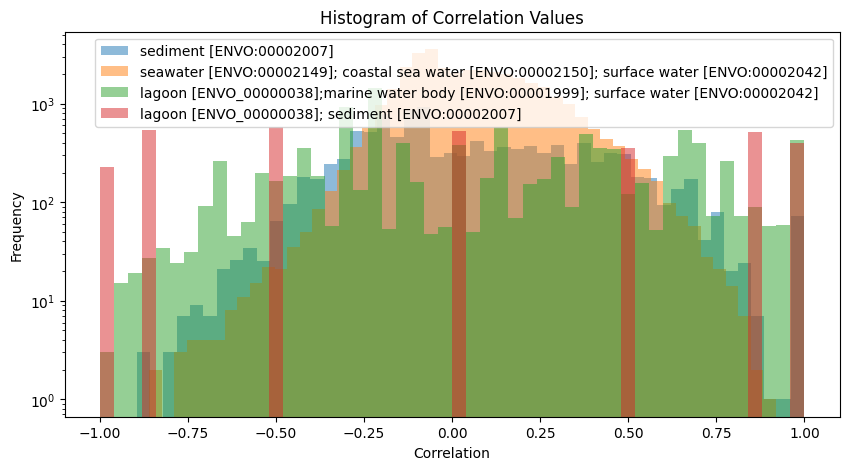

### FACTOR: sediment [ENVO:00002007] ###
Significant associations before 1972 and after 90
Associations significant before FDR but not after: 1882
### FACTOR: seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042] ###
Significant associations before 16039 and after 3614
Associations significant before FDR but not after: 12425
### FACTOR: lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042] ###
Significant associations before 1743 and after 433
Associations significant before FDR but not after: 1310
### FACTOR: lagoon [ENVO_00000038]; sediment [ENVO:00002007] ###
Significant associations before 1336 and after 628
Associations significant before FDR but not after: 708


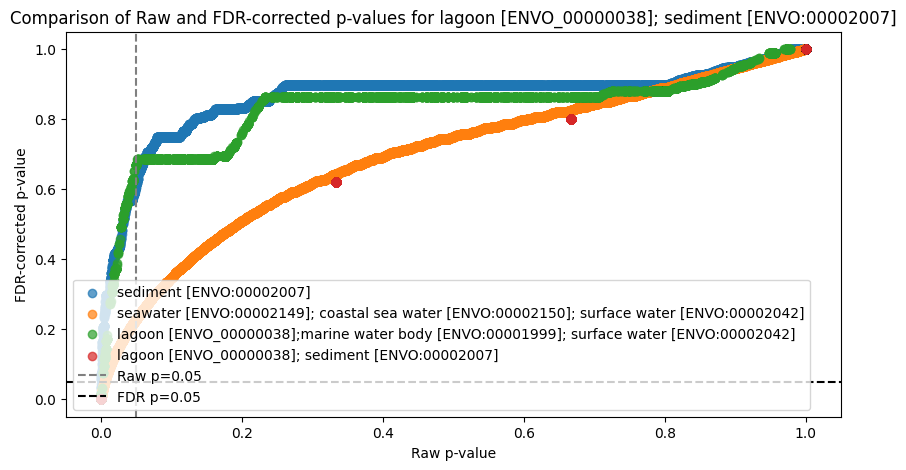

In [31]:
plot_association_histogram(spearman_taxa)
plot_fdr(spearman_taxa, PVAL)

In [32]:
for factor, dict_df in spearman_taxa.items():
    print(f"Factor: {factor}")
    nodes, edges_pos, edges_neg = interaction_to_graph_with_pvals(dict_df['correlation'], dict_df['p_vals_fdr'], pos_cutoff=0.7, neg_cutoff=-0.5, p_val_cutoff=0.05)
    break

Factor: sediment [ENVO:00002007]
Number of positive edges: 87
Number of negative edges: 3
Number of positive edges: 87
Number of negative edges: 3


### 10. Downstream analysis

#### Degree centrality
- Measures the number of direct connections a node (taxon) has. High degree centrality suggests a taxon is highly connected and may play a central role in the community.
- i.e. **keystone taxa**
#### Betweenness
- how often a node appears on the shortest paths between other nodes. Taxa with high betweenness may act as bridges or bottlenecks in the network.

In [33]:
network_results = build_interaction_graphs(spearman_taxa)

Factor: sediment [ENVO:00002007]
Number of positive edges: 87
Number of negative edges: 3
Factor: seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042]
Number of positive edges: 884
Number of negative edges: 74
Factor: lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042]
Number of positive edges: 430
Number of negative edges: 3
Factor: lagoon [ENVO_00000038]; sediment [ENVO:00002007]
Number of positive edges: 400
Number of negative edges: 228


#### Jaccard similarity of edge sets

In [34]:
df_jaccard = pairwise_jaccard_lower_triangle(network_results, edge_type='edges_pos')
display(df_jaccard)

df_jaccard = pairwise_jaccard_lower_triangle(network_results, edge_type='edges_neg')
display(df_jaccard)

df_jaccard = pairwise_jaccard_lower_triangle(network_results, edge_type='all')
display(df_jaccard)

,sediment [ENVO:00002007],seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042],lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042],lagoon [ENVO_00000038]; sediment [ENVO:00002007]
sediment [ENVO:00002007],NaN,NaN,NaN,NaN
seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042],0.004137,NaN,NaN,NaN
lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042],0.001938,0.016241,NaN,NaN
lagoon [ENVO_00000038]; sediment [ENVO:00002007],0.004124,0.01502,0.007282,NaN


,sediment [ENVO:00002007],seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042],lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042],lagoon [ENVO_00000038]; sediment [ENVO:00002007]
sediment [ENVO:00002007],NaN,NaN,NaN,NaN
seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042],0.0,NaN,NaN,NaN
lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042],0.0,0.0,NaN,NaN
lagoon [ENVO_00000038]; sediment [ENVO:00002007],0.0,0.013423,0.0,NaN


,sediment [ENVO:00002007],seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042],lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042],lagoon [ENVO_00000038]; sediment [ENVO:00002007]
sediment [ENVO:00002007],NaN,NaN,NaN,NaN
seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042],0.004794,NaN,NaN,NaN
lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042],0.001916,0.015328,NaN,NaN
lagoon [ENVO_00000038]; sediment [ENVO:00002007],0.007013,0.021907,0.006641,NaN


In [ ]:
def network_results_df(network_results, factor_name):
    out = pd.DataFrame(columns=[factor_name, 'centrality', 'top_betweenness', 'bottom_betweenness', 'total_nodes', 'total_edges'])
    for factor, dict_results in network_results.items():
        out = pd.concat([out, pd.DataFrame([{
            factor_name: factor,
            'centrality': dict_results['degree_centrality'],
            'top_betweenness': dict_results['top_betweenness'],
            'bottom_betweenness': dict_results['bottom_betweenness'],
            'total_nodes': dict_results['total_nodes'],
            'total_edges': dict_results['total_edges']
        }])], ignore_index=True)

    return out

def create_centrality_dataframe(network_results, factor_name):
    df_centrality = pd.DataFrame(columns=[factor_name, 'node', 'centrality'])

    for factor, dict_results in network_results.items():
        for node, centrality in dict_results['degree_centrality']:
            df_centrality = pd.concat([df_centrality, pd.DataFrame({
            factor_name: [factor],
            'node': [node],
            'centrality': [centrality]
        })], ignore_index=True)

    return df_centrality

In [39]:
df_results = network_results_df(network_results, FACTOR)
df_centrality = create_centrality_dataframe(network_results, FACTOR)

/tmp/ipykernel_20142/3188879841.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_centrality = pd.concat([df_centrality, pd.DataFrame({


In [38]:
# How many share the same nodes?
sum(df_centrality['node'].value_counts() > 1)

2

In [40]:
df_results.head()

,environment (material),centrality,top_betweenness,bottom_betweenness,total_nodes,total_edges
0,sediment [ENVO:00002007],"[((2949, 2949;sk_Eukaryota;k_unclassified_uncl...","[((1752722, 1752722;sk_Bacteria;k_unclassified...","[((976, 976;sk_Bacteria;k_unclassified_Bactero...",150,90
1,seawater [ENVO:00002149]; coastal sea water [E...,"[((60594, 60594;sk_Eukaryota;k_unclassified_un...","[((88547, 88547;sk_Eukaryota;k_unclassified_un...","[((976, 976;sk_Bacteria;k_unclassified_Bactero...",269,958
2,lagoon [ENVO_00000038];marine water body [ENVO...,"[((2918, 2918;sk_Eukaryota;k_unclassified_uncl...","[((976, 976;sk_Bacteria;k_unclassified_Bactero...","[((976, 976;sk_Bacteria;k_unclassified_Bactero...",147,433
3,lagoon [ENVO_00000038]; sediment [ENVO:00002007],"[((976, 976;sk_Bacteria;k_unclassified_Bactero...","[((976, 976;sk_Bacteria;k_unclassified_Bactero...","[((976, 976;sk_Bacteria;k_unclassified_Bactero...",80,628


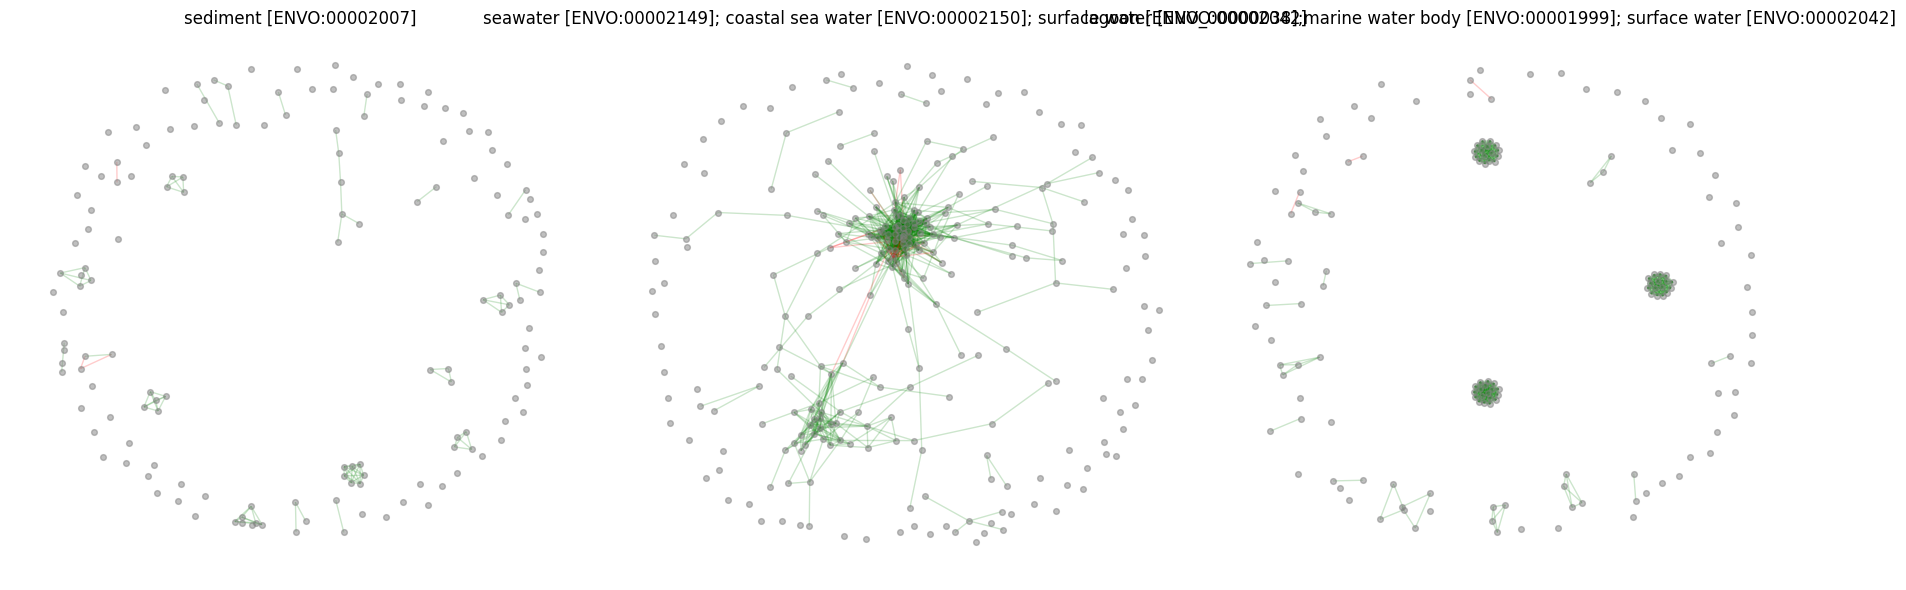

In [41]:
plot_network(network_results, spearman_taxa)

### Create a high-level function for all of the above

In [ ]:
# this takes params dictionary

def network_analysis(params):
    # prepare metadata
    if params['drop_metadata_duplicates']:
        full_metadata = params['metadata'].drop_duplicates(subset='replicate info', keep='first')
    else:
        full_metadata = params['metadata']

    ssu_filled = fill_taxonomy_placeholders(params["data"], params["taxonomy_cols"])

    print("Original DataFrame shape:", ssu_filled.shape)
    ssu_filled = remove_high_taxa(ssu_filled,
                                  taxonomy_ranks=params["taxonomy_cols"],
                                  tax_level=params["remove_high_taxa_level"])
    print("Filtered DataFrame shape:", ssu_filled.shape)

    ssu_pivot = pivot_taxonomic_data(ssu_filled)

    del ssu_filled
    ssu_filt = prevalence_cutoff(ssu_pivot, percent=params['prevalence_cutoff'], skip_columns=0)
    del ssu_pivot
    ssu_rarefied = rarefy_table(ssu_filt, depth=params['rarefy_depth'], axis=1)
    del ssu_filt

    groups = split_metadata(full_metadata, params['factor'])

    for groups_key in list(groups.keys()):
        print(f"{groups_key}: {len(groups[groups_key])} samples")
        if len(groups[groups_key]) < 3:
            del groups[groups_key]
            print(f"Warning: {groups_key} has less than 3 samples, therefore removed.")

    split_taxonomy = split_taxonomic_data_pivoted(ssu_rarefied, groups)

    spearman_taxa = spearman_from_taxonomy(split_taxonomy)

    for factor, d in spearman_taxa.items():
        pvals_fdr = fdr_pvals(d['p_vals'], pval_cutoff=params['fdr_cutoff'])
        spearman_taxa[factor]['p_vals_fdr'] = pvals_fdr

    plot_fdr(spearman_taxa, params['fdr_cutoff'])
    plot_association_histogram(spearman_taxa)

    network_results = build_interaction_graphs(
        spearman_taxa,
        pos_cutoff=params["network_pos_cutoff"],
        neg_cutoff=params["network_neg_cutoff"],
        p_val_cutoff=params["fdr_cutoff"],
    )

    print('Jaccard Similarity (Positive Edges):')
    display(pairwise_jaccard_lower_triangle(network_results, edge_type='edges_pos'))
    print('Jaccard Similarity (Negative Edges):')
    display(pairwise_jaccard_lower_triangle(network_results, edge_type='edges_neg'))
    print('Jaccard Similarity (All Edges):')
    display(pairwise_jaccard_lower_triangle(network_results, edge_type='all'))

    res_df = network_results_df(network_results, params['factor'])
    display(res_df)

    df_centrality = create_centrality_dataframe(network_results, params['factor'])
    display(df_centrality)

    plot_network(network_results, spearman_taxa)

    return


params = {
    "data": ssu,
    "metadata": full_metadata,
    "taxonomy_cols": ['superkingdom', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species'],
    "remove_high_taxa_level": 'phylum',
    'prevalence_cutoff': 10,
    'rarefy_depth': None,
    'drop_metadata_duplicates': True,
    'factor': 'environment (material)',
    'fdr_cutoff': 0.05,
    "network_pos_cutoff": 0.5,
    "network_neg_cutoff": -0.3,
}

Original DataFrame shape: (111320, 9)


100%|██████████| 218/218 [01:04<00:00,  3.38it/s]
INFO | momics.taxonomy | Number of bad taxa at phylum: 9
INFO | momics.taxonomy | Unmapped taxa at phylum: ['Candidatus_Altiarchaeota', 'Hemichordata', 'Aquificae', 'Coprothermobacterota', 'Candidatus_Verstraetearchaeota', 'Orthonectida', 'Chrysiogenetes', 'Parabasalia', 'Candidatus_Rokubacteria']


Filtered DataFrame shape: (19926, 9)
Minimum rarefaction depth: 5467
sediment [ENVO:00002007]: 13 samples
seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042]: 66 samples
lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042]: 6 samples
seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]: 2 samples
lagoon [ENVO_00000038]; sediment [ENVO:00002007]: 3 samples
Removed 117 rows with all zeros for sediment [ENVO:00002007].
Removed 1 rows with all zeros for seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042].
Removed 128 rows with all zeros for lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042].
Removed 188 rows with all zeros for lagoon [ENVO_00000038]; sediment [ENVO:00002007].
### FACTOR: sediment [ENVO:00002007] ###
Significant associations before 1910 and after 89
Associations significant before FDR but not after: 1821
### FACTOR: sea

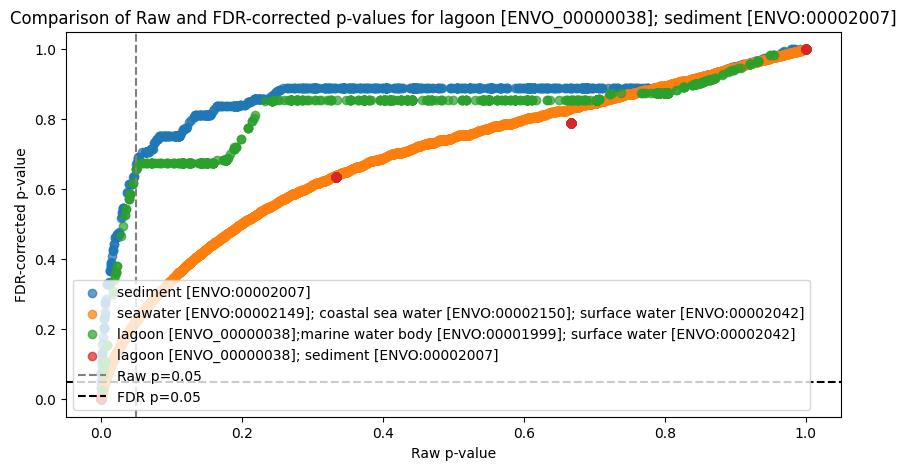

values in the triangle: 11781
values in the triangle: 36315
values in the triangle: 10153
values in the triangle: 3403


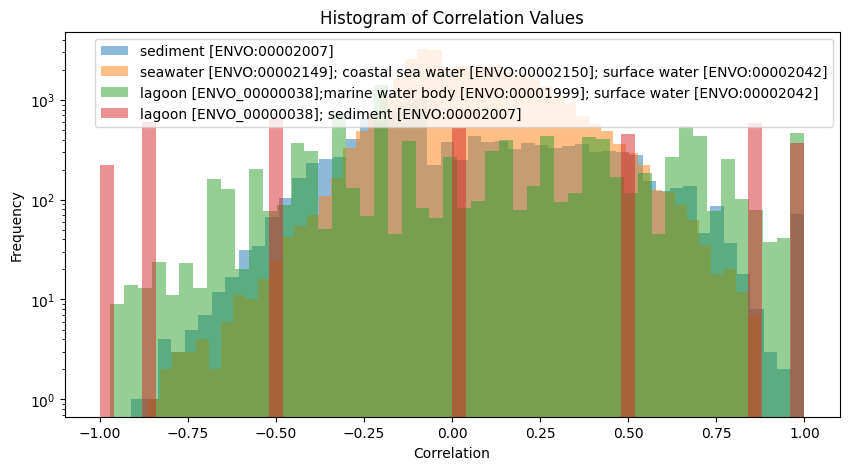

Factor: sediment [ENVO:00002007]
Number of positive edges: 87
Number of negative edges: 2
Factor: seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042]
Number of positive edges: 930
Number of negative edges: 369
Factor: lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042]
Number of positive edges: 467
Number of negative edges: 3
Factor: lagoon [ENVO_00000038]; sediment [ENVO:00002007]
Number of positive edges: 369
Number of negative edges: 223
Jaccard Similarity (Positive Edges):


,sediment [ENVO:00002007],seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042],lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042],lagoon [ENVO_00000038]; sediment [ENVO:00002007]
sediment [ENVO:00002007],NaN,NaN,NaN,NaN
seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042],0.005935,NaN,NaN,NaN
lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042],0.005445,0.023443,NaN,NaN
lagoon [ENVO_00000038]; sediment [ENVO:00002007],0.002198,0.015637,0.013333,NaN


Jaccard Similarity (Negative Edges):


,sediment [ENVO:00002007],seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042],lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042],lagoon [ENVO_00000038]; sediment [ENVO:00002007]
sediment [ENVO:00002007],NaN,NaN,NaN,NaN
seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042],0.0,NaN,NaN,NaN
lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042],0.0,0.00813,NaN,NaN
lagoon [ENVO_00000038]; sediment [ENVO:00002007],0.0,0.015437,0.0,NaN


Jaccard Similarity (All Edges):


,sediment [ENVO:00002007],seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042],lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042],lagoon [ENVO_00000038]; sediment [ENVO:00002007]
sediment [ENVO:00002007],NaN,NaN,NaN,NaN
seawater [ENVO:00002149]; coastal sea water [ENVO:00002150]; surface water [ENVO:00002042],0.005797,NaN,NaN,NaN
lagoon [ENVO_00000038];marine water body [ENVO:00001999]; surface water [ENVO:00002042],0.005396,0.020773,NaN,NaN
lagoon [ENVO_00000038]; sediment [ENVO:00002007],0.007396,0.023268,0.011429,NaN


,environment (material),centrality,top_betweenness,bottom_betweenness,total_nodes,total_edges
0,sediment [ENVO:00002007],"[((28009, 28009;sk_Eukaryota;k_unclassified_un...","[((1752722, 1752722;sk_Bacteria;k_unclassified...","[((976, 976;sk_Bacteria;k_unclassified_Bactero...",154,89
1,seawater [ENVO:00002149]; coastal sea water [E...,"[((1224, 1224;sk_Bacteria;k_unclassified_Prote...","[((1224, 1224;sk_Bacteria;k_unclassified_Prote...","[((1239, 1239;sk_Bacteria;k_unclassified_Firmi...",270,1299
2,lagoon [ENVO_00000038];marine water body [ENVO...,"[((2867, 2867;sk_Eukaryota;k_unclassified_uncl...","[((1224, 1224;sk_Bacteria;k_unclassified_Prote...","[((976, 976;sk_Bacteria;k_unclassified_Bactero...",143,470
3,lagoon [ENVO_00000038]; sediment [ENVO:00002007],"[((976, 976;sk_Bacteria;k_unclassified_Bactero...","[((976, 976;sk_Bacteria;k_unclassified_Bactero...","[((976, 976;sk_Bacteria;k_unclassified_Bactero...",83,592


/tmp/ipykernel_16000/3188879841.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_centrality = pd.concat([df_centrality, pd.DataFrame({


,environment (material),node,centrality
0,sediment [ENVO:00002007],"(28009, 28009;sk_Eukaryota;k_unclassified_uncl...",0.039216
1,sediment [ENVO:00002007],"(33859, 33859;sk_Eukaryota;k_unclassified_uncl...",0.039216
2,sediment [ENVO:00002007],"(88548, 88548;sk_Eukaryota;k_unclassified_uncl...",0.039216
3,sediment [ENVO:00002007],"(198625, 198625;sk_Eukaryota;k_unclassified_un...",0.039216
4,sediment [ENVO:00002007],"(766107, 766107;sk_Eukaryota;k_unclassified_un...",0.039216
5,sediment [ENVO:00002007],"(1288895, 1288895;sk_Eukaryota;k_unclassified_...",0.039216
6,sediment [ENVO:00002007],"(1498967, 1498967;sk_Eukaryota;k_unclassified_...",0.039216
7,sediment [ENVO:00002007],"(44055, 44055;sk_Eukaryota;k_unclassified_uncl...",0.032680
8,sediment [ENVO:00002007],"(47932, 47932;sk_Eukaryota;k_unclassified_uncl...",0.032680
9,sediment [ENVO:00002007],"(77299, 77299;sk_Eukaryota;k_unclassified_uncl...",0.032680


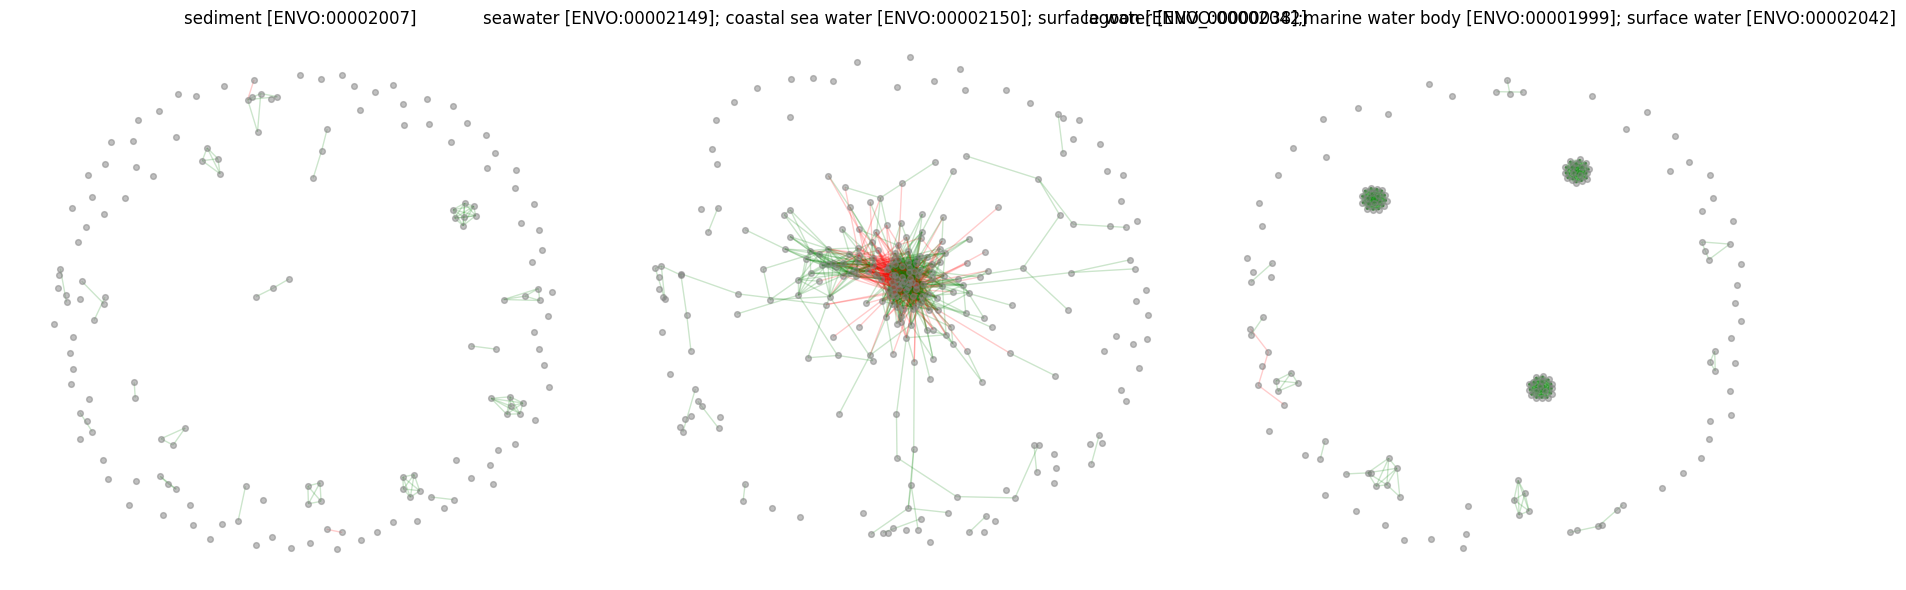

In [16]:
# run everything
network_analysis(params)

In [ ]:
# plot separate graphs for each season and save them
for season in ['Summer', 'Autumn', 'Winter']:
    fig, ax = plt.subplots(figsize=(10, 10))
    G = network_results[season]['graph']
    colors = nx.get_edge_attributes(G, 'color')
    pos = nx.spring_layout(G, k=0.2, iterations=50, seed=42)
    nx.draw_networkx_nodes(G, pos, ax=ax, alpha=alpha, node_color='grey', node_size=25)
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=alpha-0.3, edge_color=list(colors.values()), width=1.5)
    # ax.set_title(season)
    ax.axis('off')
    plt.title(f" {season}", fontsize=20)
    plt.tight_layout()
    plt.savefig(f"seasonal_trends_{season}.png", dpi=300)
    plt.close()

In [60]:
# plot separate graphs for each season and save them
for season in ['Summer', 'Autumn', 'Winter']:
    fig, ax = plt.subplots(figsize=(20, 20))
    G = network_results[season]['graph']
    colors = nx.get_edge_attributes(G, 'color')
    pos = nx.spring_layout(G, k=0.2, iterations=50, seed=42)
    nx.draw_networkx_nodes(G, pos, ax=ax, alpha=alpha, node_color='grey', node_size=100)
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=alpha-0.3, edge_color=list(colors.values()), width=3)
    # ax.set_title(season)
    ax.axis('off')
    plt.title(f" {season}", fontsize=44)
    plt.tight_layout()
    plt.savefig(f"seasonal_trends_{season}_2x.png", dpi=300)
    plt.close()

## Look into the weird islands

In [48]:
G1 = network_results[list(bray_taxa.keys())[0]]['graph'].copy()
G1.remove_nodes_from(list(nx.isolates(G1)))

In [49]:
for i, c in enumerate(nx.connected_components(G1)):
    print(f"Island {i+1}: {c}")

Island 1: {(1117, '1117;sk_Bacteria;k_unclassified_Cyanobacteria;p_Cyanobacteria;c_;o_;f_;g_;s_'), (2836, '2836;sk_Eukaryota;k_unclassified_Bacillariophyta;p_Bacillariophyta;c_;o_;f_;g_;s_')}
Island 2: {(201174, '201174;sk_Bacteria;k_unclassified_Actinobacteria;p_Actinobacteria;c_;o_;f_;g_;s_'), (1802339, '1802339;sk_Bacteria;k_unclassified_Candidatus_Tectomicrobia;p_Candidatus_Tectomicrobia;c_;o_;f_;g_;s_'), (1224, '1224;sk_Bacteria;k_unclassified_Proteobacteria;p_Proteobacteria;c_;o_;f_;g_;s_')}
Island 3: {(1239, '1239;sk_Bacteria;k_unclassified_Firmicutes;p_Firmicutes;c_;o_;f_;g_;s_'), (200795, '200795;sk_Bacteria;k_unclassified_Chloroflexi;p_Chloroflexi;c_;o_;f_;g_;s_'), (2864, '2864;sk_Eukaryota;k_unclassified_unclassified_Dinophyceae;p_unclassified_Dinophyceae;c_Dinophyceae;o_;f_;g_;s_'), (204428, '204428;sk_Bacteria;k_unclassified_Chlamydiae;p_Chlamydiae;c_;o_;f_;g_;s_')}
Island 4: {(72553, '72553;sk_Eukaryota;k_unclassified_unclassified_Dinophyceae;p_unclassified_Dinophyceae;c_

Island 1: {72037, 1161, 589449, 33836, 33849, 4762, 1118}
72037 Hexanauplia,crustaceans
1161 Nostocales, cyanobacteria
589449 Mediophyceae, diatoms
33836 Coscinodiscophyceae, diatoms
33849,Bacillariophyceae, diatoms
4762, Oomycota, 
1118, Chroococcales, cyanobacteria

Island 2: {1129, 1890505, 140493, 6448, 38834, 2570650, 1485085, 37471}
Synechococcus, cyanobacteria
Chroococcidiopsidales, cyano
Tentaculata, comb jellies
gastropods
green algae
Scytomonadidae
NCBI BLAST name: euglenoids

Flabellinia Smirnov et al. 2005
NCBI BLAST name: eukaryotes

Phyllopharyngea
NCBI BLAST name: ciliates


Island 3: {1162, 1009422, 6101, 1150, 147550}
cyano
NCBI BLAST name: verrucomicrobia
Rank: species, bacterium
anthozoans
cyano
NCBI BLAST name: ascomycete fungi
Rank: class

Island 10: {1890464, 42113, 2682468, 556282, 65582, 33103, 194287, 162481, 1890449, 47251, 1890450, 27929, 5754, 35675, 50557, 30302}
cyano
Clitellata
NCBI BLAST name: segmented worms

Pyramimonadaceae Korshikov 1938
NCBI BLAST name: green algae

Jakobida
NCBI BLAST name: eukaryotes

Polycystinea
NCBI BLAST name: eukaryotes

Ulvophyceae Mattox and Stewart, 1984
NCBI BLAST name: green algae

Heterotrichea
NCBI BLAST name: ciliates

Microbotryomycetes R. Bauer, Begerow, J.P. Samp., M. Weiss & Oberw., 2006
NCBI BLAST name: basidiomycete fungi

Microcystaceae Elenkin, 1933 in [Elenkin AA (1933)]
NCBI BLAST name: cyanobacteria

Leptolyngbya
cyano

Aphanothecaceae, cyano

Calcarea
NCBI BLAST name: sponges

Acanthamoeba
NCBI BLAST name: eukaryotes

Pelagophyceae Andersen & Saunders 1993
NCBI BLAST name: pelagophytes

Insecta
Genbank common name: insects

Appendicularia 1)
Genbank common name: appendicularians
NCBI BLAST name: tunicates

## Tests
### Assert pivot and filter equal to filter and pivot

In [68]:
# pivot and filter the ssu
ssu_pivot = pivot_taxonomic_data(ssu, normalize=None, rarefy_depth=None)
split_taxonomy = split_taxonomic_data_pivoted(
    ssu_pivot,
    groups
)

# filter and pivot after
split_taxonomy2 = split_taxonomic_data(
    ssu,
    groups
)
ssu_pivot2 = pivot_taxonomic_data(split_taxonomy2['Autumn'], normalize=None, rarefy_depth=None)

Removed 5722 rows with all zeros for Spring.
Removed 2541 rows with all zeros for Summer.
Removed 1508 rows with all zeros for Autumn.
Removed 3979 rows with all zeros for Winter.


/tmp/ipykernel_56142/2865140595.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['taxonomic_concat'] = (


In [69]:
assert ssu_pivot2.shape == split_taxonomy['Autumn'].shape, f"Shapes do not match: {ssu_pivot2.shape} != {split_taxonomy['Autumn'].shape}"

### Plot matrices

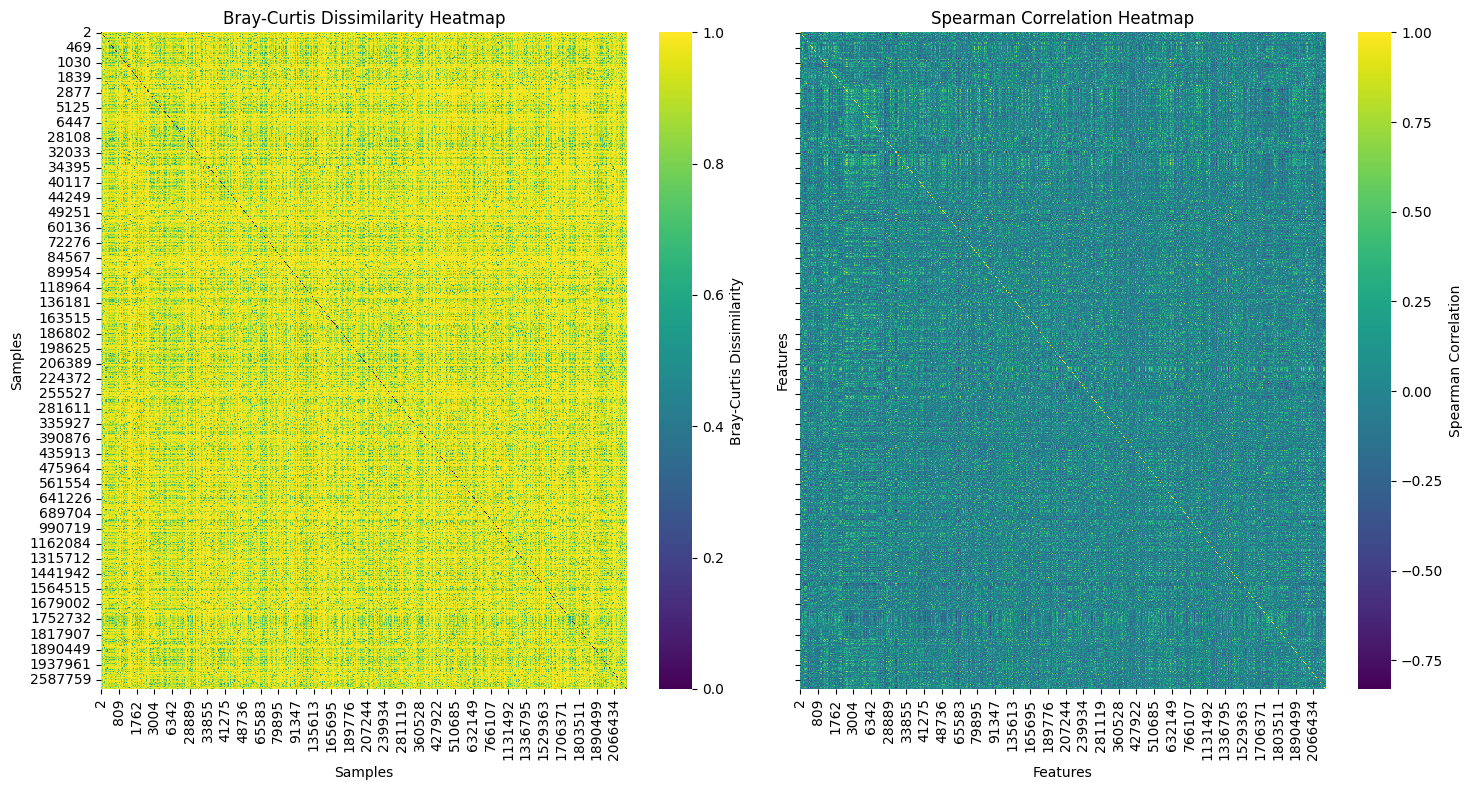

In [ ]:
def plot_bray_curtis_heatmap(df: pd.DataFrame, title: str = "Bray-Curtis Dissimilarity", cmap: str = "viridis") -> None:
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, cmap=cmap, cbar_kws={'label': 'Bray-Curtis Dissimilarity'})
    plt.title(title)
    plt.xlabel("Samples")
    plt.ylabel("Samples")
    plt.show()

# Plot the Bray-Curtis heatmap
# plot_bray_curtis_heatmap(bray_curtis_df, title="Bray-Curtis Dissimilarity Heatmap", cmap="viridis")

plt.subplots(1, 2, figsize=(15, 8), sharey=True)
plt.subplot(1, 2, 1)
sns.heatmap(bray_taxa['Autumn'], cmap="viridis", cbar_kws={'label': 'Bray-Curtis Dissimilarity'})
plt.title("Bray-Curtis Dissimilarity Heatmap")
plt.xlabel("Samples")
plt.ylabel("Samples")

plt.subplot(1, 2, 2)
sns.heatmap(spearman_taxa['Autumn'], cmap="viridis", cbar_kws={'label': 'Spearman Correlation'})
plt.title("Spearman Correlation Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


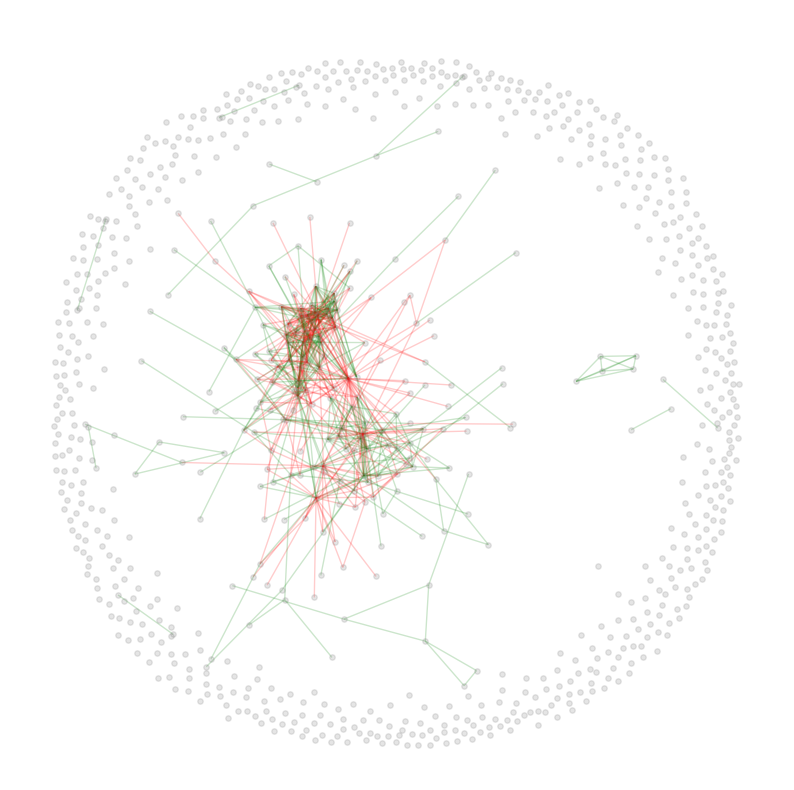

In [148]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.2, iterations=50)
pl_nodes = nx.draw_networkx_nodes(G, pos, alpha=0.2, node_color='grey', node_size=15)
pl_edges = nx.draw_networkx_edges(G, alpha=0.2, pos=pos, edge_color=colors.values())
plt.axis('off')
plt.show()

In [59]:
# Create an artificial SSU abundance table
ssu_test = pd.DataFrame({
    'Sample1': [10, 20, 30, 60],
    'Sample2': [5, 15, 25, 55],
    'Sample3': [0, 10, 20, 70]
}, index=['FeatureA', 'FeatureB', 'FeatureC', 'FeatureD'])

print(ssu_test)

          Sample1  Sample2  Sample3
FeatureA       10        5        0
FeatureB       20       15       10
FeatureC       30       25       20
FeatureD       60       55       70


In [62]:
ssu_rarefied = rarefy_table(ssu_test, depth=None, axis=1)

100


In [63]:
ssu_rarefied.head()

,Sample1,Sample2,Sample3
FeatureA,9,5,0
FeatureB,17,15,10
FeatureC,24,25,20
FeatureD,50,55,70
